In [171]:
# Import stress/strain profiles
from concreteproperties.stress_strain_profile import (
    ConcreteLinearNoTension, 
    RectangularStressBlock, 
    SteelElasticPlastic
)

## Import materials
from concreteproperties.material import Concrete, SteelBar

## Import geometry functions for creating rectangular sections
from sectionproperties.pre.library.concrete_sections import concrete_rectangular_section
from sectionproperties.pre.library.primitive_sections import rectangular_section
from concreteproperties.pre import add_bar
# from concreteproperties.pre import add_bar_rectangular_array

## Import analysis section
from concreteproperties.concrete_section import ConcreteSection

# Define Concrete Material
### All units in kips and inches

In [172]:
wc = 0.15 # kcf
fpc = 10 # ksi
Ec = 33 * ((wc * 1000) ** 1.5) * ((fpc * 1000) ** 0.5) / 1000 # ksi
# phi_bearing = 0.65
eps_cu = 0.003

In [173]:
def calculate_beta_1(fpc: float) -> float:
    """
    Calculate beta_1 in accordance with ACI 318-14 Table 22.2.2.4.3.

    Args:
    fpc: f'c in ksi
    """
    if fpc >= 2.5 and fpc <= 4.0:
        beta_1 = 0.85
    elif fpc > 4.0 and fpc < 8.0:
        beta_1 = 0.85 - (0.5 * (fpc - 4))
    elif fpc >= 8.0:
        beta_1 = 0.65
    else:
        print("f'c is less than 2.5ksi - assuming beta_1 = 0.85.")
        return 0.85
    return beta_1
beta_1 = calculate_beta_1(10.)
print(beta_1)

0.65


In [174]:
def calc_modulus_of_rupture(fpc: float) -> float:
    """
    Calculate modulus of rupture, f_r in accordance with ACI 318.

    Args:
    fpc: f'c in ksi
    """
    fr = 7.5 * ((fpc * 1000) ** 0.5) / 1000 # ksi
    return fr

In [175]:
fr = calc_modulus_of_rupture(10)
fr

0.75

In [176]:
# only takes compression and stress is linear
concrete_service = ConcreteLinearNoTension(
    elastic_modulus=Ec,
    ultimate_strain=eps_cu,
    compressive_strength=0.85*fpc
)

# Ultimate stress-strain profile
beta_1 = calculate_beta_1(fpc)
concrete_ultimate = RectangularStressBlock(
    compressive_strength=fpc,
    alpha=0.85,
    gamma=beta_1,
    ultimate_strain=eps_cu

)

# Define the concrete material
concrete = Concrete(
    name=f"{fpc} ksi Concrete",
    density = wc / (12**3), # ksi
    stress_strain_profile=concrete_service,
    colour='lightgrey',
    ultimate_stress_strain_profile=concrete_ultimate,
    flexural_tensile_strength=fr
)

# Define Rebar Material

In [177]:
fy = 60 # ksi
Es = 29000 # ksi
eps_fracture = 0.2 # ACI doesn't define a fracture strain.. used judgement for now
rebar_density = 0.490 # kcf

In [178]:
# Rebar stress-strain profile
steel_elastic_plastic = SteelElasticPlastic(
    yield_strength=fy,
    elastic_modulus=Es,
    fracture_strain=eps_fracture
)

# Rebar material
# SteelBar will lump the areas at their centroid
steel = SteelBar(
    name=f"Grade {fy} Rebar",
    density=rebar_density / (12**3), # ksi
    stress_strain_profile=steel_elastic_plastic,
    colour="black"
)

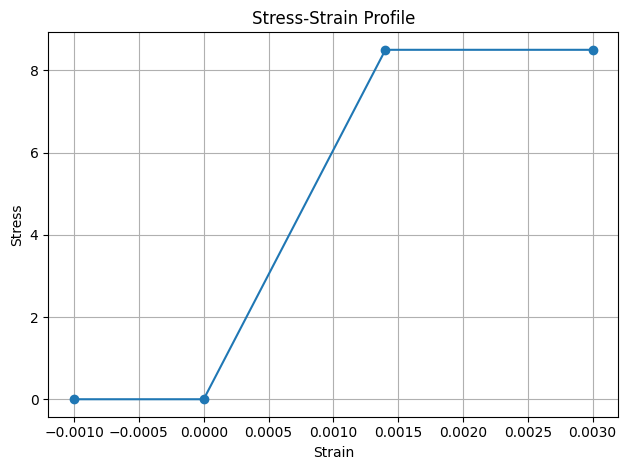

<Axes: title={'center': 'Stress-Strain Profile'}, xlabel='Strain', ylabel='Stress'>

In [179]:
concrete_service.plot_stress_strain()

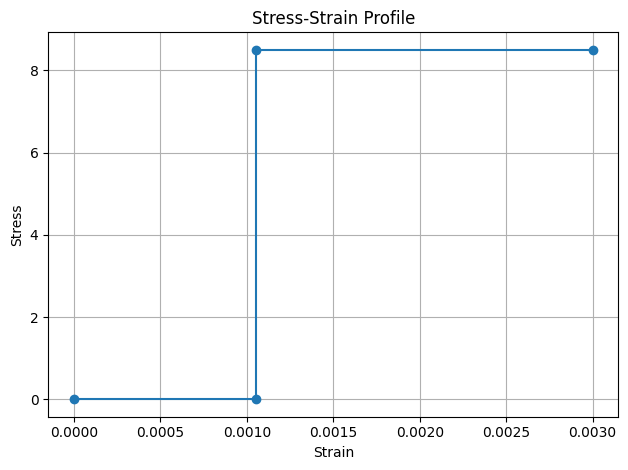

<Axes: title={'center': 'Stress-Strain Profile'}, xlabel='Strain', ylabel='Stress'>

In [180]:
concrete_ultimate.plot_stress_strain()

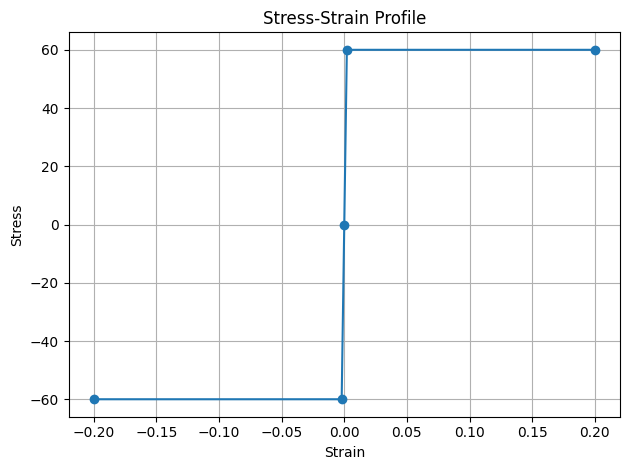

<Axes: title={'center': 'Stress-Strain Profile'}, xlabel='Strain', ylabel='Stress'>

In [181]:
steel_elastic_plastic.plot_stress_strain()

In [182]:
def create_concrete_ACI318(fpc: float, wc: float, eps_cu: float=0.003):
    """
    Returns a concreteproperties concrete material with values
    calculated per ACI 318-14.
    
    Args:
    fpc: f'c in ksi
    wc: unit weight of concrete in kcf
    eps_cu: ultimate crushing strain of concrete """

    Ec = 33 * ((wc * 1000) ** 1.5) * ((fpc * 1000) ** 0.5) / 1000 # ksi
    # only takes compression and stress is linear
    concrete_service = ConcreteLinearNoTension(
        elastic_modulus=Ec,
        ultimate_strain=eps_cu,
        compressive_strength=0.85*fpc
    )
    
    # Ultimate stress-strain profile
    beta_1 = calculate_beta_1(fpc)
    concrete_ultimate = RectangularStressBlock(
        compressive_strength=fpc,
        alpha=0.85,
        gamma=beta_1,
        ultimate_strain=eps_cu
    
    )
    
    # Define the concrete material
    concrete = Concrete(
        name=f"{fpc} ksi Concrete",
        density = wc / (12**3), # ksi
        stress_strain_profile=concrete_service,
        colour='lightgrey',
        ultimate_stress_strain_profile=concrete_ultimate,
        flexural_tensile_strength=fr
    )
    return concrete

# From module

In [183]:
from eng_module import aci_318_14_materials as aci_matl

In [184]:
conc = aci_matl.create_concrete_ACI318(10)
conc

Concrete(name='10 ksi Concrete', density=8.680555555555556e-05, stress_strain_profile=ConcreteLinearNoTension(strains=[-0.001, 0, 0.0014020648359364992, 0.003], stresses=[0, 0, 8.5, 8.5], elastic_modulus=6062.487113388366, ultimate_strain=0.003, compressive_strength=8.5), colour='lightgrey', meshed=True, ultimate_stress_strain_profile=RectangularStressBlock(strains=[0, 0.00105, 0.00105, 0.003], stresses=[0, 0, 8.5, 8.5], compressive_strength=10, alpha=0.85, gamma=0.65, ultimate_strain=0.003), flexural_tensile_strength=0.75)

In [185]:
steel = aci_matl.create_rebar_ACI318(60)
steel

SteelBar(name='Grade 60 Rebar', density=0.00028356481481481483, stress_strain_profile=SteelElasticPlastic(strains=[-0.3, -0.0020689655172413794, 0, 0.0020689655172413794, 0.3], stresses=[-60, -60, 0, 60, 60], yield_strength=60, elastic_modulus=29000.0, fracture_strain=0.3), colour='black', meshed=False)

# Define Geometry

In [186]:
conc_geom = rectangular_section(24, 14, conc).align_center()

sectionproperties.pre.geometry.Geometry
object at: 0x14a3fe540
Material: 10 ksi Concrete


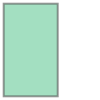

In [187]:
conc_geom

In [199]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import ram_column_schedule as rcs
import columns

In [215]:
b = 14
h = 24
cover = 1.5
d_tie = .375
d_bar = 0.75
sx = columns.calc_spacing_per_side(b, 3)
sy = columns.calc_spacing_per_side(h, 1)
sx, sy

(4.75, 6.5)

In [202]:
# origin = (0, 0)
x1 = -b/2 + cover + d_tie + d_bar / 2
y1 = h/2 - cover - d_tie - d_bar /2


In [203]:
x1, y1

(-4.75, 9.75)

In [209]:
def generate_bar_coordinates(b, h, n_bars_b, n_bars_h, cover, d_tie, d_bar):

    sx = columns.calculate_spacing_per_side(b, n_bars_b)
    sy = columns.calculate_spacing_per_side(h, n_bars_h)

    x_coords = []
    y_coords = []
    x1 = -b/2 + cover + d_tie + d_bar / 2
    y1 = h/2 - cover - d_tie - d_bar / 2
    # x_coords.append(x1)

    # top and bottom coordinates contain the corners!
    # top coordinates
    for i in range(n_bars_b):
        x_coords.append(x1 + i * sx)
        y_coords.append(y1)
        
    # bottom coordinates
    for i in range(n_bars_b):
        x_coords.append(x1 + i * sx)
        y_coords.append(-y1)

    # left coordinates
    for i in range(1, n_bars_h-1):
        x_coords.append(x1)
        y_coords.append(y1 - i * sy)

    # right coordinates
    for i in range(1, n_bars_h-1):
        x_coords.append(-x1)
        y_coords.append(y1 - i * sy)


    return list(zip(x_coords, y_coords))

In [211]:
bar_coords = columns.generate_bar_coordinates(14, 24, 2, 1, d_bar=.75)
bar_coords

[[-4.75, 9.75], [4.75, 9.75], [-4.75, -9.75], [4.75, -9.75]]

In [212]:
for bar_coord in bar_coords:
    area = 0.44
    x, y = bar_coord
    conc_geom = add_bar(conc_geom, area, steel, x, y)

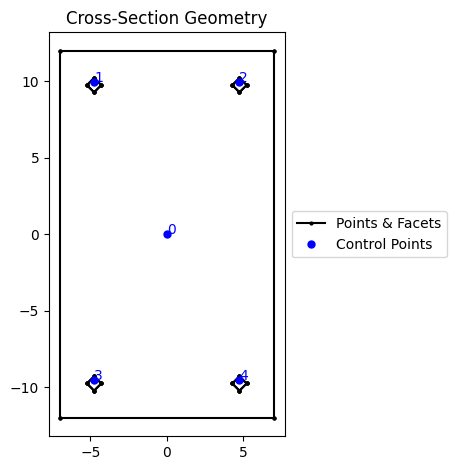

<Axes: title={'center': 'Cross-Section Geometry'}>

In [216]:
conc_geom.plot_geometry()

# Analysis Section

In [34]:
conc_sec = ConcreteSection(conc_geom)

In [156]:
bending_about_x_int_dia = conc_sec.moment_interaction_diagram(theta=0, n_points=25)

Output()

In [157]:
bending_about_x_int_dia.results

[UltimateBendingResults(theta=0, d_n=inf, k_u=inf, n=3082.600409696919, m_x=-1.2789769243681803e-12, m_y=-2.8421709430404007e-13, m_xy=1.3101760682293513e-12, label=None),
 UltimateBendingResults(theta=0, d_n=24.0, k_u=1.103448275862069, n=1996.9874107105593, m_x=8421.227118502196, m_y=-9.094947017729282e-13, m_xy=8421.227118502196, label=None),
 UltimateBendingResults(theta=0, d_n=23.000000041666667, k_u=1.0574712662835248, n=1918.5370837481487, m_x=8699.5690715931, m_y=-7.105427357601002e-15, m_xy=8699.5690715931, label=None),
 UltimateBendingResults(theta=0, d_n=22.000000083333333, k_u=1.011494256704981, n=1833.1052383290507, m_x=8952.532509850727, m_y=5.115907697472721e-13, m_xy=8952.532509850727, label=None),
 UltimateBendingResults(theta=0, d_n=21.000000125, k_u=0.9655172471264367, n=1746.3716504171928, m_x=9161.512251452938, m_y=-1.4210854715202004e-14, m_xy=9161.512251452938, label=None),
 UltimateBendingResults(theta=0, d_n=20.000000166666666, k_u=0.9195402375478927, n=1658.69

In [136]:
def calculate_phi(tensile_strains: list[float], fy: float = 60, Es: float = 29000, reinf_type: str = 'other') -> list[float]:
    tensile_yield_strain = fy / Es
    phis = []
    if reinf_type == 'other':
        for ts in tensile_strains:
            if ts <= tensile_yield_strain:
                phi = 0.65
                phis.append(phi)
            elif ts > tensile_yield_strain and ts < 0.005:
                phi = 0.65 + 0.25 * (ts - tensile_yield_strain) / (0.005 - tensile_yield_strain)
                phis.append(phi)
            elif ts >= 0.005:
                phi = 0.9
                phis.append(phi)
    else:
        print("Spiral ties not yet implemented!")
    return phis

In [137]:
tensile_strains = []
n = []
m_x = []
m_y = []
for result in bending_about_x_int_dia.results:

    dn = round(result.d_n, 3)
    if dn > 24: # REPLACE WITH LARGEST COLUMN DIM IN DIRECTION OF ANALYSIS
        dn = 24 # REPLACE WITH LARGEST COLUMN DIM IN DIRECTION OF ANALYSIS
    ku = round(result.k_u, 3)
    if dn > 0.1:
        tensile_strain = 0.003 * (dn/ku - dn)/dn
    else:
        tensile_strain = .1 # ARBITRARILY LARGE STRAIN
    tensile_strains.append(tensile_strain)

    n.append(result.n)
    m_x.append(result.m_x)
    m_y.append(result.m_y)
tensile_strains

[-0.0030000000000000005,
 -0.0002801450589301902,
 -0.00016177861873226115,
 -3.264094955489599e-05,
 0.00010559006211180134,
 0.0002608695652173914,
 0.0004324942791762014,
 0.0006231884057971015,
 0.0008363171355498722,
 0.0010760869565217392,
 0.001347826086956522,
 0.0016583850931677021,
 0.002016722408026756,
 0.0020675675675675682,
 0.0024347826086956515,
 0.002928853754940712,
 0.0035217391304347826,
 0.004246376811594203,
 0.005152173913043479,
 0.006316770186335404,
 0.007869565217391303,
 0.010043478260869567,
 0.013304347826086957,
 0.018739130434782605,
 0.025037383177570094,
 0.029608695652173913,
 0.06221739130434783,
 0.1]

In [138]:
phis = calculate_phi(tensile_strains)
phis

[0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.6812020460358056,
 0.723343408509649,
 0.7739130434782608,
 0.8357203751065644,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9]

In [139]:
import numpy as np

In [140]:
m_x = np.asarray(m_x)
m_y = np.asarray(m_y)
n = np.asarray(n)

In [218]:
type(n)

numpy.ndarray

In [217]:
type(phis)

list

In [141]:
phi_Pn = phis * n
phi_Pn

array([ 2.00369027e+03,  1.29804182e+03,  1.24704910e+03,  1.19151840e+03,
        1.13514157e+03,  1.07815481e+03,  1.02046180e+03,  9.61944855e+02,
        9.02458560e+02,  8.41821165e+02,  7.79802451e+02,  7.16263010e+02,
        6.54892255e+02,  6.46565240e+02,  6.24648643e+02,  5.97271859e+02,
        5.66238071e+02,  5.30061130e+02,  4.92842140e+02,  4.11315303e+02,
        3.21808344e+02,  2.28502698e+02,  1.47585351e+02,  6.77080672e+01,
       -5.60721512e-02, -4.00096637e+01, -1.67985322e+02, -2.37600376e+02])

In [148]:
phi_Mn_x = phis * m_x
phi_Mn_x/12

array([-6.92779167e-14,  4.56149802e+02,  4.71226658e+02,  4.84928844e+02,
        4.96248580e+02,  5.05149441e+02,  5.11679505e+02,  5.15897532e+02,
        5.17876111e+02,  5.17705974e+02,  5.15502052e+02,  5.11449438e+02,
        5.06851290e+02,  5.06074104e+02,  5.15908672e+02,  5.27464973e+02,
        5.39473234e+02,  5.52347155e+02,  5.55000076e+02,  5.09819530e+02,
        4.56328231e+02,  3.96837689e+02,  3.34997633e+02,  2.70233463e+02,
        2.13201586e+02,  1.79106506e+02,  6.77296950e+01,  5.35499990e-05])

In [143]:
phi_Mn_y = phis * m_y
phi_Mn_y

array([-1.84741111e-13, -5.91171556e-13, -4.61852778e-15,  3.32534000e-13,
       -9.23705556e-15,  1.06226139e-13, -1.75504056e-13, -1.82431847e-13,
       -1.13153931e-13, -5.20739007e-13, -2.90967250e-13,  1.10844667e-13,
       -2.21689334e-13, -2.58637556e-13,  1.83928803e-13, -5.13966404e-14,
       -5.49898291e-14, -1.06886707e-13,  0.00000000e+00,  0.00000000e+00,
        3.83693077e-14, -1.53477231e-13,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.16500000e-05])

In [144]:
import matplotlib.pyplot as plt

In [145]:
phi_Pn_max = 0.65 * 0.8 * (
    0.85 * 10 * (14 * 24 - 8 * 0.44) + 60 * 8 * 0.44
)
phi_Pn_max

1579.3855999999998

In [146]:
adjusted_phi_Pns = []
for p in phi_Pn:
    if p >= phi_Pn_max:
        adjusted_phi_Pns.append(phi_Pn_max)
    else:
        adjusted_phi_Pns.append(p)

In [149]:
adjusted_phi_Pns

[1579.3855999999998,
 1298.0418169618636,
 1247.0491044362966,
 1191.518404913883,
 1135.1415727711753,
 1078.1548074446937,
 1020.4618036999636,
 961.9448551404821,
 902.4585597486711,
 841.821165004827,
 779.8024510538912,
 716.2630104693509,
 654.8922546006513,
 646.5652397039905,
 624.6486427011494,
 597.2718589117957,
 566.2380714840854,
 530.0611301796562,
 492.84214042658607,
 411.31530325816453,
 321.80834404997165,
 228.5026982754155,
 147.58535093519623,
 67.70806716922262,
 -0.056072151180763544,
 -40.009663675265365,
 -167.98532248512,
 -237.60037603512]

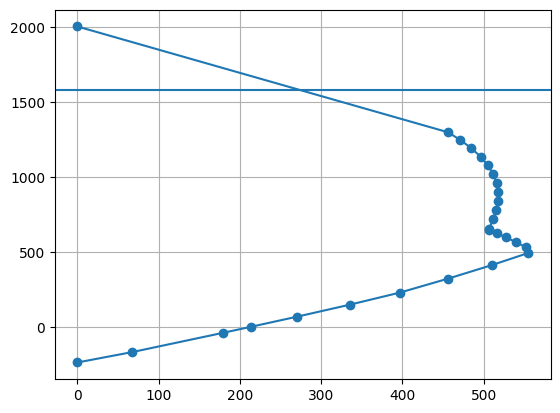

In [153]:
plt.plot(phi_Mn_x/12, phi_Pn, '-o')
plt.axhline(phi_Pn_max)
plt.grid()
plt.show()

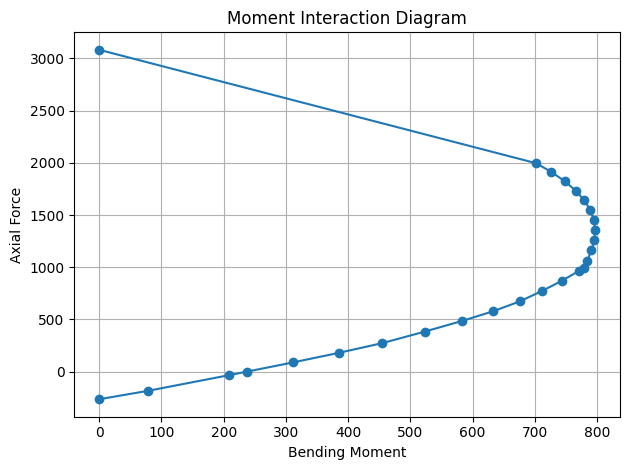

<Axes: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [76]:
bending_about_x_int_dia.plot_diagram(n_scale=1, m_scale=1/12, labels=True)